<a href="https://colab.research.google.com/github/dchlseo/DataScienceProjects/blob/main/DeepLearningBasics/TensorFlow/03_DL_flow_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


### EDA

In [3]:
print(train_x.shape)
print(test_x.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
print(train_y.shape)
print(test_y.shape)

(60000,)
(10000,)


In [6]:
print(train_x.dtype)
print(test_x.dtype)
print(train_y.dtype)
print(test_y.dtype)

uint8
uint8
uint8
uint8


In [13]:
image = train_x[77]
image.shape

(28, 28)

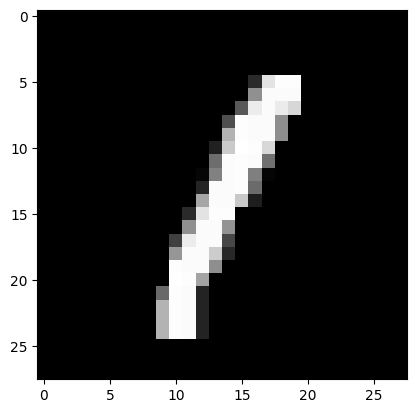

In [14]:
plt.imshow(image, 'gray')
plt.show()

In [31]:
y_unique, y_counts = np.unique(train_y, return_counts=True)
df_view = pd.DataFrame(data={'count': y_counts}, index=y_unique)
df_view

,count
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851
9,5949


In [32]:
df_view.sort_values(by='count', ascending=False)

,count
1,6742
7,6265
3,6131
2,5958
9,5949
0,5923
6,5918
8,5851
4,5842
5,5421


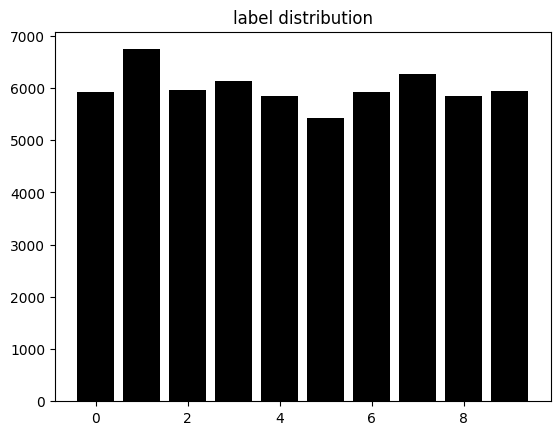

In [33]:
plt.bar(x=y_unique, height=y_counts, color='black')
plt.title('label distribution')
plt.show()

In [34]:
image = tf.constant(image)

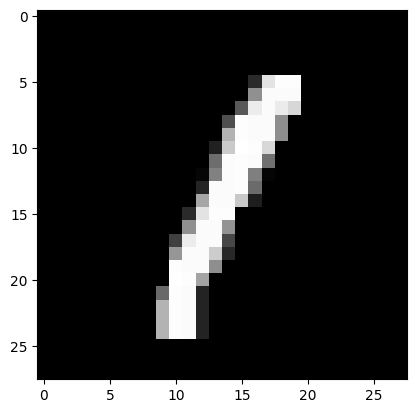

In [35]:
plt.imshow(image, 'gray')
plt.show()

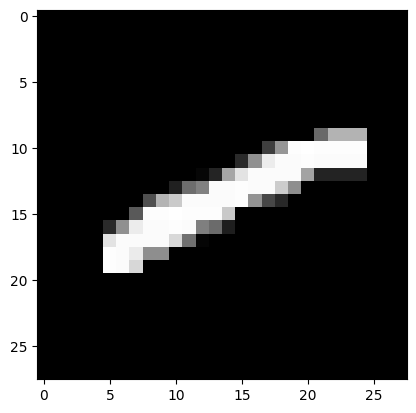

In [36]:
plt.imshow(tf.transpose(image), 'gray')
plt.show()

### Preprocessing

#### Data validation

In [37]:
def validate_pixel_scale(x):
  return 255 >= x.max() and 0 <= x.min()

In [38]:
validated_train_x = np.array([x for x in train_x if validate_pixel_scale(x)])
validated_train_y = np.array([y for x, y in zip(train_x, train_y) if validate_pixel_scale(x)])

In [39]:
print(validated_train_x.shape)
print(validated_train_y.shape)

(60000, 28, 28)
(60000,)


#### Scaling

In [40]:
def scale(x):
  return (x/255.0).astype(np.float32)  # range 0~1

In [41]:
scaled_train_x = np.array([scale(x) for x in validated_train_x])

0.0
1.0


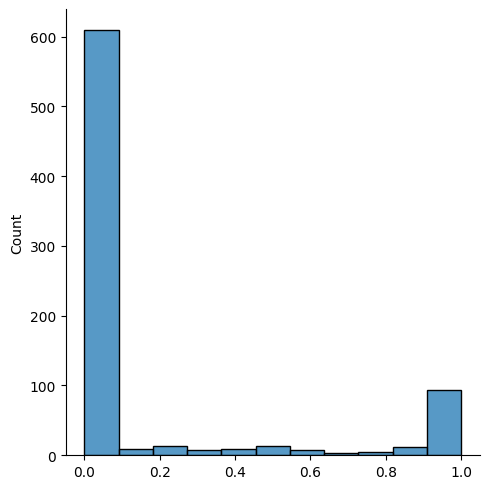

In [46]:
# unit test
sample = scale(validated_train_x[777])
print(sample.min())
print(sample.max())

sns.displot(sample.reshape(-1), kde=False)
plt.show()

#### Flattening

In [48]:
flattened_train_x = scaled_train_x.reshape((60000, -1))

In [49]:
flattened_train_x.shape

(60000, 784)

#### Label encoding (one-hot encoding)

In [ ]:
tf.keras.utils.to_categorical()

In [50]:
ohe_train_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_train_y])

In [51]:
ohe_train_y.shape

(60000, 10)

### Class for data preprocessing

In [52]:
class DataLoader():

  def __init__(self):
    (self.train_x, self.train_y), \
      (self.test_x, self.test_y) = tf.keras.datasets.mnist.load_data()

  def validate_pixel_scale(self, x):
    return 255 >= x.max() and 0 <= x.min()

  def scale(self, x):
    return (x/255.0).astype(np.float32)  # range 0~1

  def preprocess_dataset(self, dataset):
    (feature, target) = dataset

    validated_x = np.array([x for x in feature if self.validate_pixel_scale(x)])
    validated_y = np.array([y for x, y in zip(feature, target) if self.validate_pixel_scale(x)])

    # scaling
    scaled_x = np.array([self.scale(x) for x in validated_x])

    # flattening
    flattened_x = scaled_x.reshape((scaled_x.shape[0], -1))

    # label encoding
    ohe_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_y])

    return flattened_x, ohe_y

  def get_train_dataset(self):
    return self.preprocess_dataset((self.train_x, self.train_y))

  def get_test_dataset(self):
    return self.preprocess_dataset((self.test_x, self.test_y))


In [53]:
mnist_loader = DataLoader()

In [55]:
train_x, train_y = mnist_loader.get_train_dataset()
test_x, test_y = mnist_loader.get_test_dataset()

In [56]:
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(60000, 784) float32
(60000, 10) float32
(10000, 784) float32
(10000, 10) float32


### Modeling

#### Defining model

In [57]:
from tensorflow.keras.layers import Dense, Activation

In [59]:
model = tf.keras.Sequential()
model.add(Dense(15, input_dim=784))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 activation (Activation)     (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 11935 (46.62 KB)
Trainable params: 11935 (46.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training logic

In [61]:
opt = tf.keras.optimizers.SGD(0.03)  # lr=0.03
loss = tf.keras.losses.categorical_crossentropy

In [63]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

#### Execute training

In [77]:
hist = model.fit(train_x, train_y, epochs=20, batch_size=256)

Epoch 1/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3724 - accuracy: 0.9023
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3672 - accuracy: 0.9031
Epoch 3/20
235/235 [==============================] - 1s 3ms/step - loss: 0.3624 - accuracy: 0.9039
Epoch 4/20
235/235 [==============================] - 1s 3ms/step - loss: 0.3578 - accuracy: 0.9054
Epoch 5/20
235/235 [==============================] - 1s 3ms/step - loss: 0.3535 - accuracy: 0.9058
Epoch 6/20
235/235 [==============================] - 1s 3ms/step - loss: 0.3495 - accuracy: 0.9067
Epoch 7/20
235/235 [==============================] - 1s 3ms/step - loss: 0.3456 - accuracy: 0.9075
Epoch 8/20
235/235 [==============================] - 1s 3ms/step - loss: 0.3420 - accuracy: 0.9081
Epoch 9/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3386 - accuracy: 0.9086
Epoch 10/20
235/235 [==============================] - 1s 6ms/step - loss: 0.3353 - accuracy: 0.9090

Notice the output returns 'History'. We can use this to evaluate whether training was done correctly.

 #### Evaluation

In [78]:
hist.history  # loss/accuracy for each epoch

{'loss': [0.37241190671920776,
  0.36720407009124756,
  0.36237868666648865,
  0.35779422521591187,
  0.35354605317115784,
  0.3494527041912079,
  0.3456459641456604,
  0.34200841188430786,
  0.3385828137397766,
  0.33526611328125,
  0.33214056491851807,
  0.32910943031311035,
  0.32627037167549133,
  0.32353994250297546,
  0.3208925724029541,
  0.3183583617210388,
  0.3159292936325073,
  0.31358522176742554,
  0.3112802505493164,
  0.30917081236839294],
 'accuracy': [0.9022833108901978,
  0.903083324432373,
  0.9039499759674072,
  0.9053833484649658,
  0.9058333039283752,
  0.9066666960716248,
  0.9075333476066589,
  0.9081000089645386,
  0.9085666537284851,
  0.9090499877929688,
  0.9096999764442444,
  0.9104333519935608,
  0.9108666777610779,
  0.9114166498184204,
  0.9118333458900452,
  0.9125833511352539,
  0.913349986076355,
  0.9135500192642212,
  0.9138333201408386,
  0.9143000245094299]}

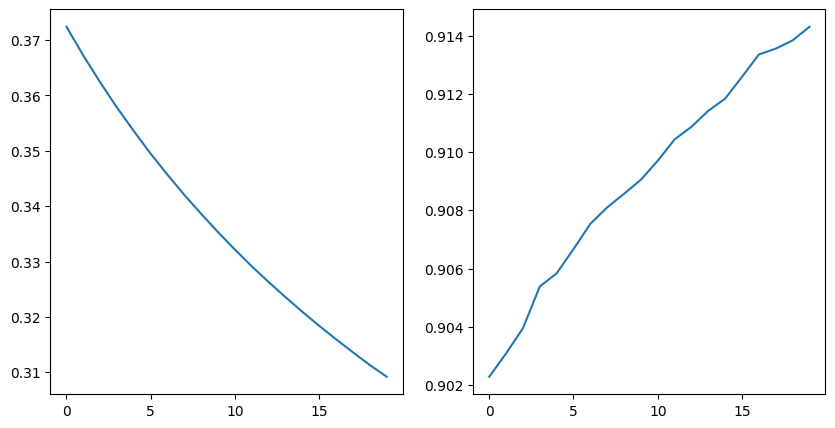

In [80]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.subplot(122)
plt.plot(hist.history['accuracy'])

plt.show()

In [81]:
model.evaluate(test_x, test_y) # returns final loss and accuracy

313/313 [==============================] - 3s 5ms/step - loss: 0.3017 - accuracy: 0.9166


[0.30167078971862793, 0.9165999889373779]

#### Post-processing

In [83]:
pred = model.predict(test_x[:1])

1/1 [==============================] - 0s 48ms/step


In [84]:
pred.argmax()

7

In [87]:
sample_img = test_x[0].reshape((28,28)) * 255

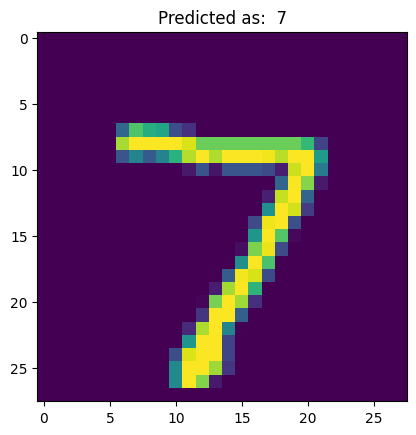

In [90]:
plt.imshow(sample_img)
plt.title(f'Predicted as:  {pred.argmax()}')
plt.show()

313/313 [==============================] - 1s 4ms/step


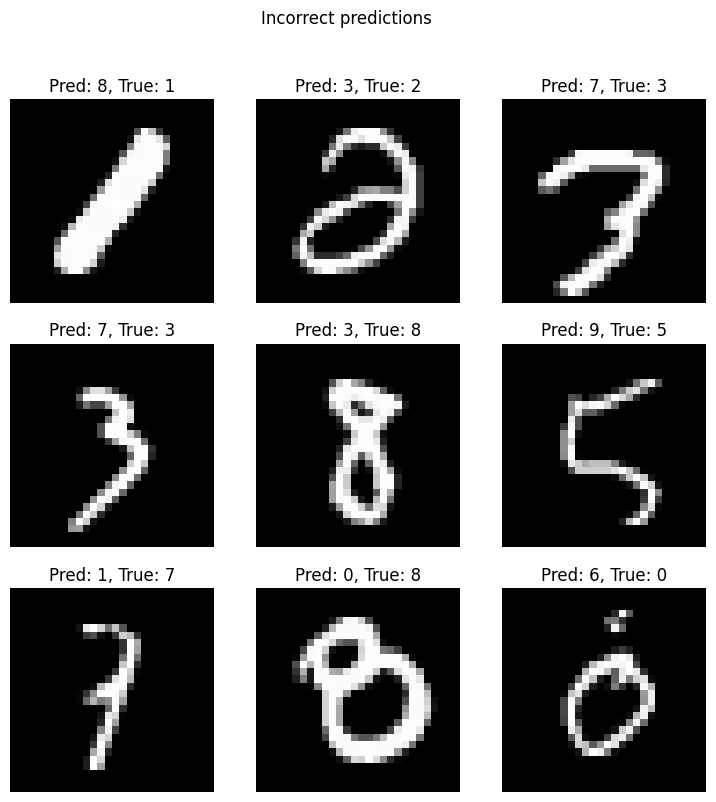

In [91]:
preds = model.predict(test_x)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(test_y, axis=1)

# Find the indices where predictions and actual values don't match
incorrect_indices = np.where(pred_classes != true_classes)[0]

# Randomly select 9 incorrect samples
incorrect_sample_indices = np.random.choice(incorrect_indices, 9, replace=False)

# Create a 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
fig.suptitle('Incorrect predictions')

# Loop through the subplot and add the images
for i, ax in enumerate(axes.flat):
    # Use incorrect_sample_indices to get the actual image index
    img_idx = incorrect_sample_indices[i]
    ax.imshow(test_x[img_idx].reshape(28, 28) * 255, cmap='gray')
    ax.set_title(f'Pred: {pred_classes[img_idx]}, True: {true_classes[img_idx]}')
    ax.axis('off')

# Display the plot
plt.show()